<a href="https://colab.research.google.com/github/mto0501/streamlit_101/blob/master/Hang_Money_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os, tarfile
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
! unzip -q /content/gdrive/MyDrive/ML_PROJECTS/VND_Banknotes_dataset.zip -d /content/gdrive/MyDrive/ML_PROJECTS/money_classification

1000/Giấy_bạc_1000_đồng.jpg:  mismatching "local" filename (1000/Giс║еy_bс║бc_1000_─Сс╗Уng.jpg),
         continuing with "central" filename version
1000/Đồng_bạc_1000_đồng (1).jpeg:  mismatching "local" filename (1000/─Рс╗Уng_bс║бc_1000_─Сс╗Уng (1).jpeg),
         continuing with "central" filename version
1000/Đồng_bạc_1000_đồng.jpeg:  mismatching "local" filename (1000/─Рс╗Уng_bс║бc_1000_─Сс╗Уng.jpeg),
         continuing with "central" filename version
20000/Đồng_bạc_20.000.jpg:  mismatching "local" filename (20000/─Рс╗Уng_bс║бc_20.000.jpg),
         continuing with "central" filename version


In [ ]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/ML_PROJECTS/money_classification')

image_count = len(list(data_dir.glob('*/*.jpg'))) ###
print(image_count)

1300


In [ ]:
import pathlib

# Let's save your project results in Google Drive
PROJECT = pathlib.Path('/content/gdrive/MyDrive/ML_PROJECTS/money_classification')    

IMG_SIZE = 224  # This is required by your pretrained-model
BATCH_SIZE = 32 #

In [ ]:
def acc_loss_graph(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()
  plt.title('Training and validation accuracy')

  plt.figure()
  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)     # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2)  # IMPORTANT

  train_generator = train_gen.flow_from_directory(
          data_dir,  
          target_size=(IMG_SIZE,IMG_SIZE),  
          batch_size=32,
          class_mode='categorical',
          shuffle=True,
          seed=42,            # IMPORTANT
          subset='training')  # IMPORTANT

  validation_generator = val_gen.flow_from_directory(
          data_dir,
          target_size=(IMG_SIZE,IMG_SIZE),
          batch_size=32,
          class_mode='categorical',
          shuffle=False,        # IMPORTANT
          seed=42,              # IMPORTANT
          subset='validation')  # IMPORTANT
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = generator_augmentation_maker()

Found 1356 images belonging to 9 classes.
Found 334 images belonging to 9 classes.


In [ ]:
  base_model = keras.applications.MobileNetV2(weights='imagenet',
                                              input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                              include_top=False)

  base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input
def model_maker():
  inputs = keras.Input(shape=(224,224,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
model = model_maker()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',     # BE CAREFUL
              metrics = ['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)]

init_epochs=5

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=init_epochs,
                    callbacks = callback)

Epoch 1/5
43/43 [==============================] - 1299s 30s/step - loss: 1.4760 - accuracy: 0.5324 - val_loss: 0.9141 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 2/5
43/43 [==============================] - 127s 3s/step - loss: 0.6848 - accuracy: 0.8075 - val_loss: 0.6070 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 3/5
43/43 [==============================] - 124s 3s/step - loss: 0.4981 - accuracy: 0.8621 - val_loss: 0.5165 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 4/5
43/43 [==============================] - 125s 3s/step - loss: 0.4006 - accuracy: 0.8835 - val_loss: 0.4439 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 5/5
43/43 [==============================] - 124s 3s/step - loss: 0.3338 - accuracy: 0.9204 - val_loss: 0.3912 - val_accuracy: 0.8892 - lr: 0.0010


### Fine-tuning

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
!mkdir -p /content/gdrive/MyDrive/ML_PROJECTS/money_classification/Result
!mkdir -p /content/gdrive/MyDrive/ML_PROJECTS/money_classification/Saved_model

RESULT            = PROJECT/'Results'
SAVED_MODEL       = RESULT/'Saved_model'

In [ ]:
# CALLBACK and TRAIN

# Stopped by EarlyStopping: model is auto-restored best weights => can CONTINUE to finetune
# Stopped by user => LOAD model_ckpt to continue
# Stopped by finishing => model saved to Saved_model

from keras.callbacks import ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint(monitor='val_loss', filepath=RESULT/'model_ckpt.h5', save_weights_only=False, save_best_only=True, verbose=1)]

init_epochs = 5
fine_tune_epochs = 15
total_epochs = init_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, 
                         validation_data=validation_generator,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callbacks)

model.save(SAVED_MODEL)

Epoch 6/20
43/43 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.9100
Epoch 00006: val_loss improved from inf to 0.38732, saving model to /content/gdrive/MyDrive/ML_PROJECTS/money_classification/Results/model_ckpt.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


43/43 [==============================] - 129s 3s/step - loss: 0.3133 - accuracy: 0.9100 - val_loss: 0.3873 - val_accuracy: 0.8922
Epoch 7/20
43/43 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9358
Epoch 00007: val_loss improved from 0.38732 to 0.37824, saving model to /content/gdrive/MyDrive/ML_PROJECTS/money_classification/Results/model_ckpt.h5
43/43 [==============================] - 125s 3s/step - loss: 0.2731 - accuracy: 0.9358 - val_loss: 0.3782 - val_accuracy: 0.8892
Epoch 8/20
43/43 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9351
Epoch 00008: val_loss improved from 0.37824 to 0.37647, saving model to /content/gdrive/MyDrive/ML_PROJECTS/money_classification/Results/model_ckpt.h5
43/43 [==============================] - 125s 3s/step - loss: 0.2479 - accuracy: 0.9351 - val_loss: 0.3765 - val_accuracy: 0.8922
Epoch 9/20
43/43 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9358
Epoch 00009: val_loss impr

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
from google.colab import files

# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving 20k.jpg to 20k.jpg
20k.jpg


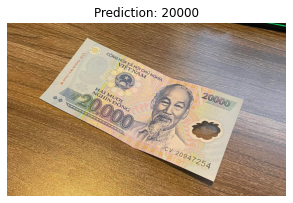

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing import image

img        = image.load_img(img_path, target_size=(224,224))
img_array  = image.img_to_array(img)
img_array  = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

for key, value in validation_generator.class_indices.items():
  if value == prediction[0].argmax():
    pred = key

plt.figure(figsize=(5,5))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title('Prediction: ' + pred.upper())
plt.axis('off')
plt.grid(b=None)
plt.show()

In [ ]:
from google.colab import files

# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving 6406.jpg_wh860.jpg to 6406.jpg_wh860.jpg
6406.jpg_wh860.jpg


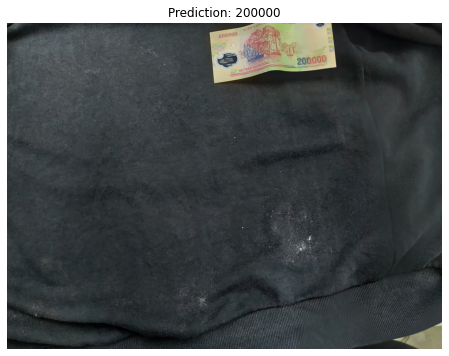

True

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True

# YOUR FILE HERE
image_path= '/content/gdrive/MyDrive/ML_PROJECTS/money_classification/200000/IMG_20190828_113815.jpg'
predict(model, image_path, IMG_SIZE)

In [ ]:
 validation_generator.class_indices.items()

dict_items([('1000', 0), ('10000', 1), ('100000', 2), ('2000', 3), ('20000', 4), ('200000', 5), ('5000', 6), ('50000', 7), ('500000', 8)])

In [ ]:
pip install opencv-python

In [ ]:
#https://github.com/mto0501 